# Distance Metrics tests 

### Can skip this middle part - just to remember where the embeddings came from
___

In [1]:
import pickle

with open('../lib/artifacts/dicts/sources.pickle', 'rb') as handle:
    sources_dict = pickle.load(handle)

with open('../lib/artifacts/dicts/targets.pickle', 'rb') as handle:
    targets_dict = pickle.load(handle)

In [2]:
sources = [('query: ' + v) for k, v in sources_dict.items()]
targets = [('query: ' + v) for k, v in targets_dict.items()]

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [4]:
from sentence_transformers import SentenceTransformer

plm = 'intfloat/multilingual-e5-small'

model = SentenceTransformer(plm, trust_remote_code=False)

# Encode
sources_emb = model.encode(sources, normalize_embeddings=True)
targets_emb = model.encode(targets, normalize_embeddings=True)

In [5]:
import pickle 

with open('../lib/artifacts/dicts/sources_emb.pickle', 'wb') as handle:
    pickle.dump(dict(zip(range(len(sources_emb)), sources_emb)), handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../lib/artifacts/dicts/targets_emb.pickle', 'wb') as handle:
    pickle.dump(dict(zip(range(len(targets_emb)), targets_emb)), handle, protocol=pickle.HIGHEST_PROTOCOL)

___

### Load embeddings from index-matched sources and targets

In [1]:
import pickle

with open('../lib/artifacts/dicts/sources_emb.pickle', 'rb') as handle:
    sources_dict = pickle.load(handle)
with open('../lib/artifacts/dicts/targets_emb.pickle', 'rb') as handle:
    targets_dict = pickle.load(handle)

In [2]:
import numpy as np
sources_emb = np.array([v for v in sources_dict.values()])
targets_emb = np.array([v for v in targets_dict.values()])

In [3]:
import sys
sys.path.insert(0, '..') # add parent folder path

In [9]:
from time import time
from tqdm import tqdm
import faiss
from distance_metrics import batch_compute_distances, batch_compute_kd_trees, evaluate_index_matched_results

metrics = {
           "Inner Product": faiss.METRIC_INNER_PRODUCT, 
           "L2": faiss.METRIC_L2, # Squared Euclidean
           "L1": faiss.METRIC_L1, # Manhatan
           "Linf": faiss.METRIC_Linf, # infinity distance
           "Camberra": faiss.METRIC_Canberra,
           # "JensenShannon": faiss.METRIC_JensenShannon, # NOTE: This is to be used between two probability arrays. So it doesn't make sense in this case.   
           # "Jaccard": faiss.METRIC_Jaccard, # NOTE: This is not working properly 
           "HNSWFlat": "HNSWFlat",
           "KD-Trees": "KD-Trees"
}

results_dict = []

for m, metric in tqdm(metrics.items(), desc="Evaluating available metrics"):

    # Track results
    top1 = 0
    top5 = 0
    top10 = 0
    total = len(sources_emb)

    # Track Encoding Time
    start = time()

    # Compute distances
    if metric == "KD-Trees":
        distance, index = batch_compute_kd_trees(feature_space=targets_emb, query=sources_emb, k=10)
    else: distance, index = batch_compute_distances(targets_emb, sources_emb, metric, m=100, k=10)

    # Compute time
    end = time()
    elapsed_seconds = end - start

    # Evaluate results
    evaluate = evaluate_index_matched_results(index)
    evaluate['metric'] = m
    evaluate['n_tests'] = total
    evaluate['elapsed_seconds'] = elapsed_seconds
    evaluate['preds_per_second_X1000'] = total/elapsed_seconds/1000

    results_dict.append(
        evaluate
    )

Evaluating available metrics:  29%|██▊       | 2/7 [00:00<00:00, 10.92it/s]

normalizing


Evaluating available metrics:  71%|███████▏  | 5/7 [00:00<00:00,  6.25it/s]

HNSWFlat


Evaluating available metrics: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


In [11]:
import pandas as pd
results_df = pd.DataFrame.from_dict(results_dict)
results_df

,top1,top5,top10,metric,n_tests,elapsed_seconds,preds_per_second_X1000
0,0.479748,0.719622,0.783978,Inner Product,2222,0.073986,30.032687
1,0.477498,0.718272,0.784878,L2,2222,0.080597,27.569209
2,0.482898,0.719622,0.776328,L1,2222,0.256344,8.668045
3,0.282628,0.454095,0.513501,Linf,2222,0.124348,17.869217
4,0.427543,0.665167,0.725023,Camberra,2222,0.168074,13.220357
5,0.437894,0.655266,0.713771,HNSWFlat,2222,0.023146,95.998676
6,0.474797,0.718722,0.786679,KD-Trees,2222,0.457060,4.861508


In [13]:
results_df.columns.tolist()

['top1',
 'top5',
 'top10',
 'metric',
 'n_tests',
 'elapsed_seconds',
 'preds_per_second_X1000']

In [25]:
from utils.plotting import parallel

In [23]:
results_df.drop(['n_tests'], axis=1, inplace=True)

In [24]:
parallel(results_df, label='metric')

## Other metrics

### eval

## Mahalanobis

In [12]:
import numpy as np
import faiss
from matplotlib import pyplot as plt

stacked = np.vstack([sources_emb, targets_emb])

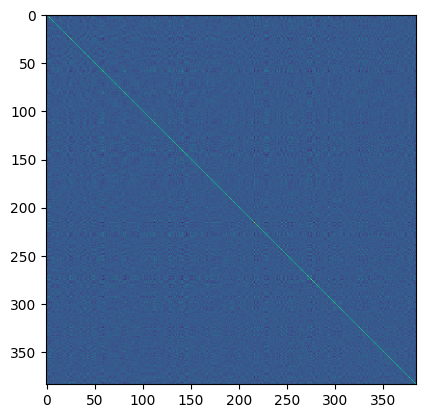

In [22]:
# compute and visualize the covariance matrix
xc = targets_emb - targets_emb.mean(0)
cov = np.dot(xc.T, xc) / xc.shape[0]
_ = plt.imshow(cov)

In [24]:
cov

array([[ 3.8286968e-04, -9.9552835e-06,  1.1587799e-07, ...,
        -4.3315598e-05, -3.3048756e-05, -1.5565014e-05],
       [-9.9552835e-06,  4.8848643e-04,  1.2768769e-05, ...,
         5.4477765e-05,  1.0735298e-04,  8.0193298e-05],
       [ 1.1587799e-07,  1.2768769e-05,  3.2220045e-04, ...,
         6.3375606e-05, -1.4427606e-05,  2.4960971e-05],
       ...,
       [-4.3315598e-05,  5.4477765e-05,  6.3375606e-05, ...,
         4.8934313e-04,  1.0738262e-05, -2.3427808e-06],
       [-3.3048756e-05,  1.0735298e-04, -1.4427606e-05, ...,
         1.0738262e-05,  4.9229956e-04,  8.6209555e-05],
       [-1.5565014e-05,  8.0193298e-05,  2.4960971e-05, ...,
        -2.3427808e-06,  8.6209555e-05,  4.1356971e-04]], dtype=float32)

In [25]:
# map the vectors back to a space where they follow a unit Gaussian
L = np.linalg.cholesky(cov)
mahalanobis_transform = np.linalg.inv(L)
y = np.dot(stacked, mahalanobis_transform.T)

LinAlgError: Matrix is not positive definite

The matrix is singular, according to the solver. That means a zero or near-zero diagonal element, so inversion is impossible...

In [ ]:
# perform L2 search in the tranformed space 
index = faiss.IndexFlatL2(16)
index.add(y[:500])
D, I = index.search(y[500:], 10)


In [ ]:
# perform L2 search in the tranformed space 
index = faiss.IndexFlatL2(16)
index.add(y[:500])
D, I = index.search(, 10)

### JensenShannon

In [19]:
distance, index = batch_compute_distances(targets_emb, sources_emb, faiss.METRIC_Jaccard, k=targets_emb.shape[0])

In [22]:
index[:5]

array([[1384,  512,  215, ..., 1789, 1845, 1620],
       [1384,  215,  690, ...,  403, 1890, 1620],
       [1384,  690,  821, ..., 1620, 1890,  403],
       [1384,  215,  690, ..., 1890,  403, 1625],
       [1384,  215,  690, ..., 1890,  403, 1625]])

In [175]:
index = faiss.index_factory(
    targets_emb.shape[1], "HNSW", faiss.METRIC_L2)
index.add(targets_emb)
distance, index = index.search(sources_emb, k=10)

In [176]:
index

array([[   0,  955,   15, ...,    7,   10,   20],
       [  15,   18,   19, ...,   13,    2,   12],
       [   1,    3,    7, ...,   13,  247,  469],
       ...,
       [2219, 2202, 2096, ..., 2100, 2174, 2217],
       [2152, 2146, 2220, ..., 2210, 2145, 2172],
       [2221,  223, 1319, ..., 1436,  988,  639]])

In [177]:
evaluate(index)

0.4198919891989199 0.6296129612961296 0.6854185418541854


## Euclidean

In [47]:
index = faiss.IndexFlatL2(targets_emb.shape[1])
index.add(targets_emb)
distance, index = index.search(np.array([sources_emb[0]]), k=targets_emb.shape[0])

In [48]:
index

array([[   0,  955,   15, ..., 1852,  222, 1887]])

# HNSW - Hierarchical Navigable Small Worlds

# HNSW Flat

In [160]:
M = 100
index = faiss.IndexHNSWFlat(targets_emb.shape[1], M)
index.add(targets_emb)
distance, index = index.search(sources_emb, k=10)

In [161]:
index

array([[   0,   15,   18, ...,   10,   20,   13],
       [  15,   18,   19, ...,   13,    2,   14],
       [   1,    3,    7, ...,   13,  247,  469],
       ...,
       [2219, 2202, 2096, ..., 2100, 2174, 2217],
       [2152, 2146, 2220, ..., 2210, 2145, 2172],
       [2221,  223, 1319, ..., 1436,  988,  639]])

0.4414941494149415 0.6620162016201621 0.7182718271827183


# KD-Trees

In [5]:
from distance_metrics import batch_compute_kd_trees
distance, index = batch_compute_kd_trees(feature_space=targets_emb, query=sources_emb, k=10)

In [6]:
index

array([[   0,  955,   15, ...,    7,   10,   20],
       [  15,   18,   19, ...,   13,   14,    2],
       [  15,   19,   18, ...,   13,  247,  469],
       ...,
       [2219, 2202, 2096, ..., 2100, 2174, 2217],
       [2152, 2220, 2146, ..., 2210, 2145, 2172],
       [2221,  223, 1319, ..., 1436,  988, 1288]])

In [7]:
evaluate_index_matched_results(index)

{'top1': 0.4747974797479748,
 'top5': 0.7187218721872187,
 'top10': 0.7866786678667866}

# Jaccard

In [34]:
from scipy.spatial import distance

distance.jaccard(sources_emb[0], targets_emb[7])

1.0